<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
PATH_TO_DATA = '/Users/zaharsaraev/Documents/Machine_learning_coursera/Final_project/'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
from datetime import datetime as dt

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    file_names = glob(path_to_csv_files+'/*') #список файлов в директории
    os.chdir(path_to_csv_files)
    freq_dict = pickle.load(open(site_freq_path,"rb")) #загружаем словарь

    df = pd.DataFrame(columns=feature_names) #создаем пустой DataFrame
    
    C = np.array([]) #Создаем пустой массив 
    y = [] #Создаем массив с ID пользователей
    format_data = "%Y-%m-%d %H:%M:%S"
    C = np.array([])
    for name in file_names: #Пробегаемся по всем файлам
        data = pd.read_csv(name)
        sites = np.hstack(np.array(data.site))
        X = []
        #Аналогично считываем все времена в одну строку
        time = np.array(data['timestamp']) #Считываем время
        time = [str(a) for a in time] #Переводим в строку 
        date = [dt.strptime(a, format_data) for a in time] #Переводим строку в дату
        timestamp = [a.timestamp() for a in date] #Переводим в timestamp
        
        userID = name
        userID = userID.replace(path_to_csv_files+'/user', '')
        userID = userID.replace('.csv', '')
        target = int(userID)
        
        for i in range(0, len(time), window_size): #Переформируем 1D массив в матрицу соответствующую размерам в длины сессии/окна
            if len(sites[i:i+session_length]) == session_length:
                values = [freq_dict[x][0] if (x in freq_dict) else 0 for x in sites[i:i+session_length]] #Переводим в ID
                time_diff = np.diff([a for a in timestamp[i:i+session_length]]) #Создаем признаки time_diff
                timespan = np.sum(time_diff)
                unique_sites = len(np.unique(sites[i:i+session_length]))
                start_hour = date[i].hour
                day_of_week = dt.isoweekday(date[i])
                X.append(np.hstack((values, time_diff, timespan, unique_sites, 
                                    start_hour, day_of_week, target)))
                
                
                
            else: #Если сессия обрезается, дополняем нулями
                values = [freq_dict[x][0] if (x in freq_dict) else 0 for x in sites[i:i+session_length]]
                time_diff = np.diff([a for a in timestamp[i:len(time)]]) #Создаем признаки time_diff
                timespan = np.sum(time_diff)
                unique_sites = len(np.unique(sites[i:i+session_length]))
                start_hour = date[i].hour
                day_of_week = dt.isoweekday(date[i])
                X.append(np.hstack((values, 
                                         np.zeros(session_length-len(sites[i:i+session_length])), time_diff, 
                                         np.zeros(session_length-len(sites[i:i+session_length])), timespan, unique_sites,
                                         start_hour, day_of_week, target)))
        
        #Добавляем сайты в строку

        if len(C) ==0: #Соединяем матрицы для каждого файла в одну (если начальная  пустая матрица, то просто присваиваем)
            C = X
        else:
            C = np.concatenate((C, X), axis=0)   
    for i, col in enumerate(feature_names):
        df[col] = C[:,i]
                            
    return(df)

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,5.0,2.0
1,4.0,5.0,2.0,5.0,2.0,5.0,5.0,6.0,7.0,4.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,5.0,3.0
2,4.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,5.0,3.0
3,1.0,2.0,2.0,8.0,2.0,5.0,9.0,6.0,10.0,11.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,5.0,1.0
4,1.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,5.0,1.0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [162]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2.75 s, sys: 75.2 ms, total: 2.83 s
Wall time: 2.91 s


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,6.0,0.0,1.0,480.0,0.0,1.0,1.0,0.0,2.0,2.0,487.0,6.0,8.0,5.0,39.0
1,7.0,8.0,7.0,4.0,9.0,10.0,11.0,12.0,9.0,13.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,19.0,30.0,8.0,8.0,5.0,39.0
2,14.0,15.0,15.0,9.0,15.0,9.0,9.0,4.0,4.0,9.0,0.0,1.0,0.0,1.0,21.0,25.0,4.0,1.0,3.0,56.0,4.0,8.0,5.0,39.0
3,12.0,15.0,15.0,16.0,17.0,13.0,18.0,19.0,20.0,21.0,56.0,1.0,31.0,0.0,0.0,3.0,0.0,0.0,0.0,91.0,9.0,8.0,5.0,39.0
4,22.0,23.0,19.0,21.0,24.0,19.0,25.0,26.0,21.0,19.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,7.0,8.0,5.0,39.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [163]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 29.6 s, sys: 1.94 s, total: 31.5 s
Wall time: 34.9 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour','day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour','day_of_week']]

In [13]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [15]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

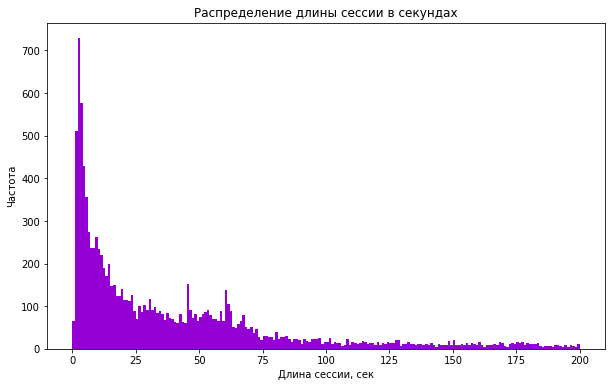

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(train_data_10users['session_timespan'], bins = 200, range = (0,200),
        color = 'darkviolet' )
plt.title('Распределение длины сессии в секундах')
plt.xlabel('Длина сессии, сек')
plt.ylabel('Частота')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

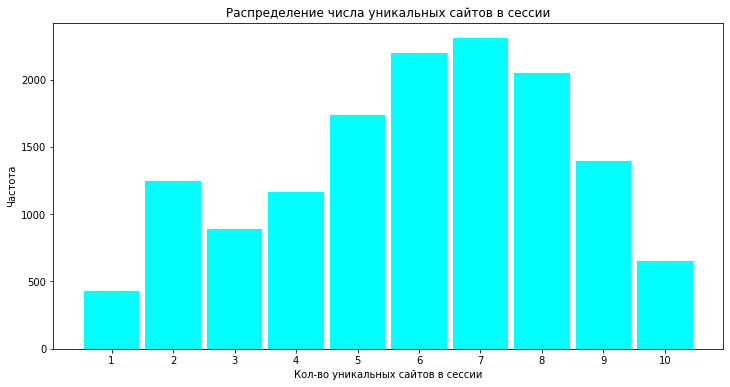

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(train_data_10users['#unique_sites'], color = 'aqua', bins = np.arange(0.5,11.5,1) , align = 'mid', rwidth = 0.9)
plt.xticks(np.arange(1,11,1))
plt.title('Распределение числа уникальных сайтов в сессии')
plt.xlabel('Кол-во уникальных сайтов в сессии')
plt.ylabel('Частота')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

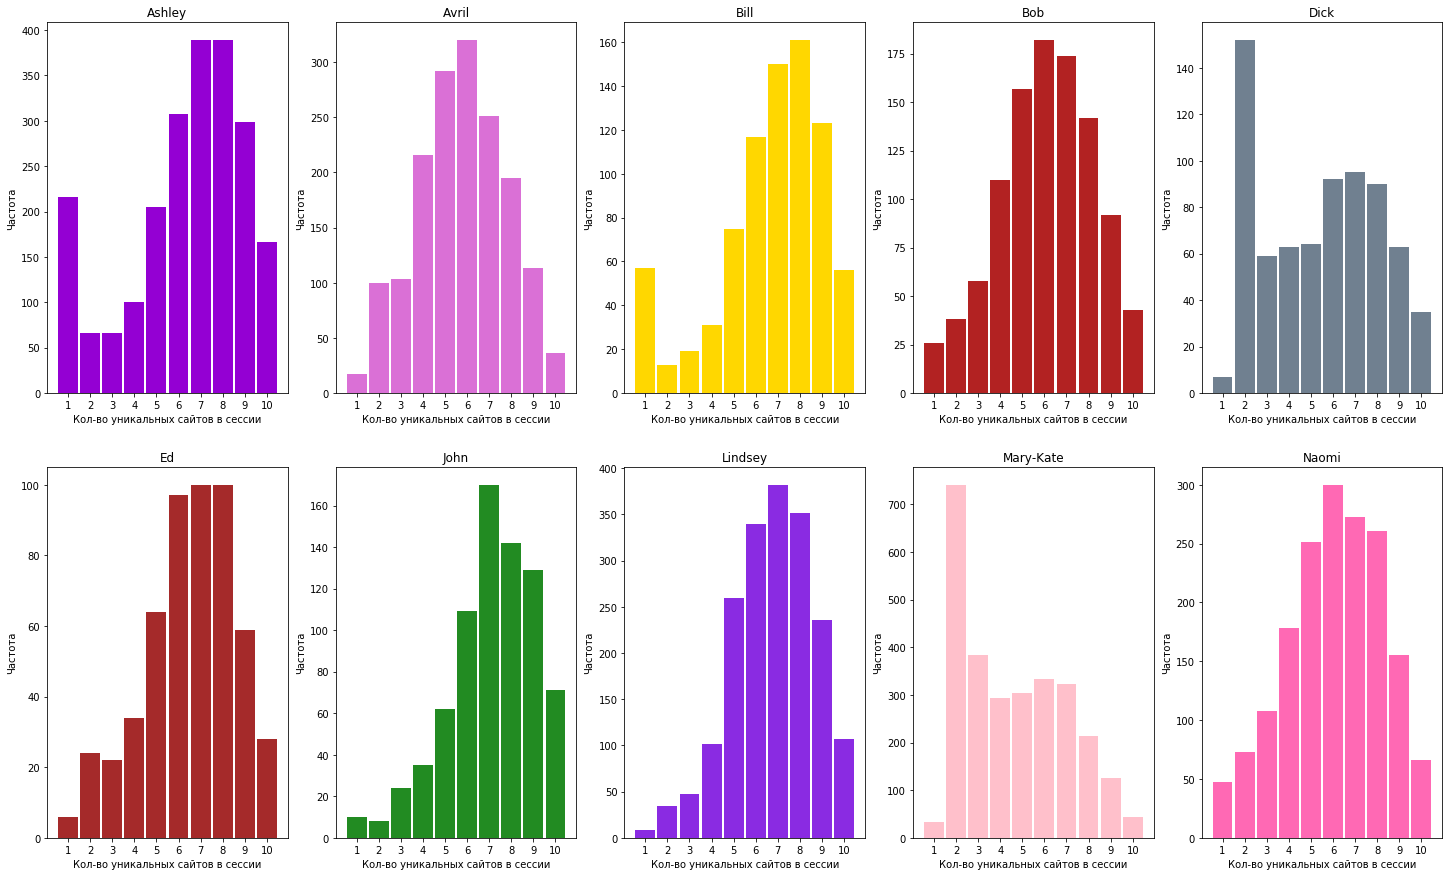

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    axes[idx//5][idx%5].hist(sub_df['#unique_sites'], color = color_dic.get(user), bins = np.arange(0.5,11.5,1) , 
                             align = 'mid', rwidth = 0.9)
    axes[idx//5][idx%5].set_title(user)
    axes[idx//5][idx%5].set_xticks(np.arange(1,11,1))
    axes[idx//5][idx%5].set_xlabel('Кол-во уникальных сайтов в сессии')
    axes[idx//5][idx%5].set_ylabel('Частота')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

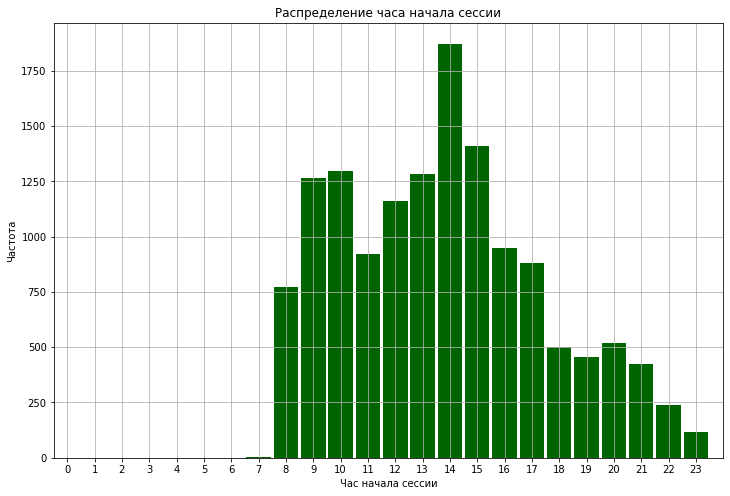

In [19]:
plt.figure(figsize=(12, 8))
train_data_10users['start_hour'].hist(color = 'darkgreen', bins = np.arange(0.5,24.5,1) , 
                                      align = 'mid', rwidth = 0.9)
plt.xticks(np.arange(0,24,1))
plt.xlim(-0.5, 24)
plt.title('Распределение часа начала сессии')
plt.xlabel('Час начала сессии')
plt.ylabel('Частота')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

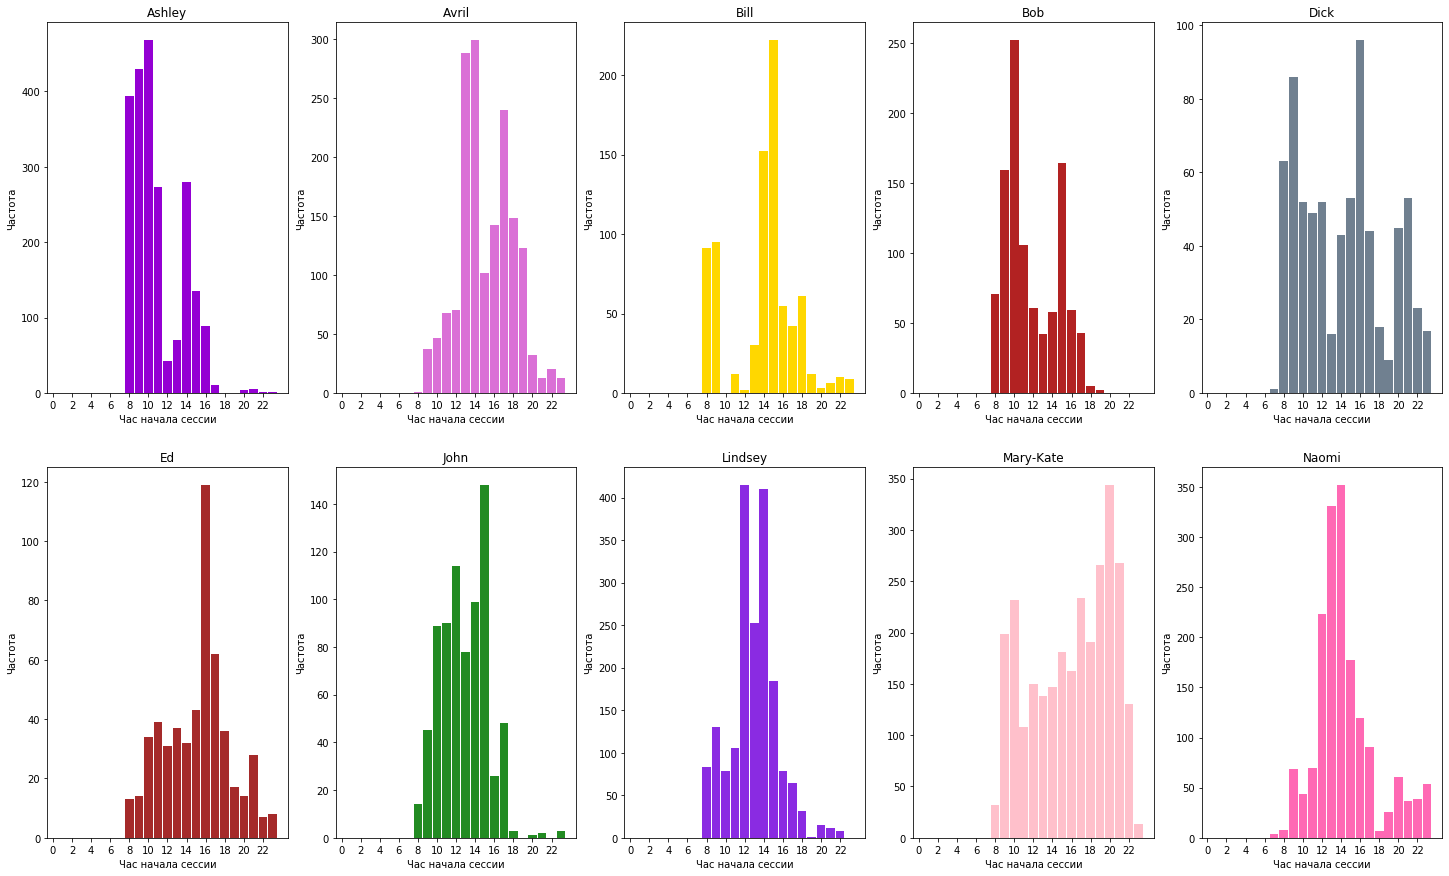

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    axes[idx//5][idx%5].hist(sub_df['start_hour'], color = color_dic.get(user),  bins = np.arange(0.5,24.5,1) , 
                                      align = 'mid', rwidth = 0.9)
    axes[idx//5][idx%5].set_title(user)
    axes[idx//5][idx%5].set_xticks(np.arange(0,24,2))
    axes[idx//5][idx%5].set_xlabel('Час начала сессии')
    axes[idx//5][idx%5].set_ylabel('Частота')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

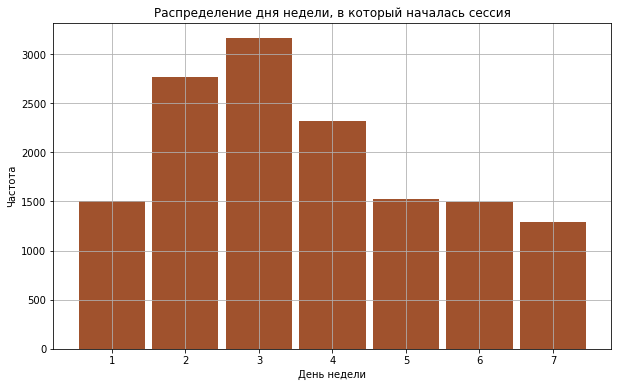

In [30]:
plt.figure(figsize=(10, 6))
train_data_10users['day_of_week'].hist(color = 'sienna', bins = np.arange(0.5,8.5,1) , 
                                      align = 'mid', rwidth = 0.9)
plt.title('Распределение дня недели, в который началась сессия')
plt.xlabel('День недели')
plt.ylabel('Частота')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

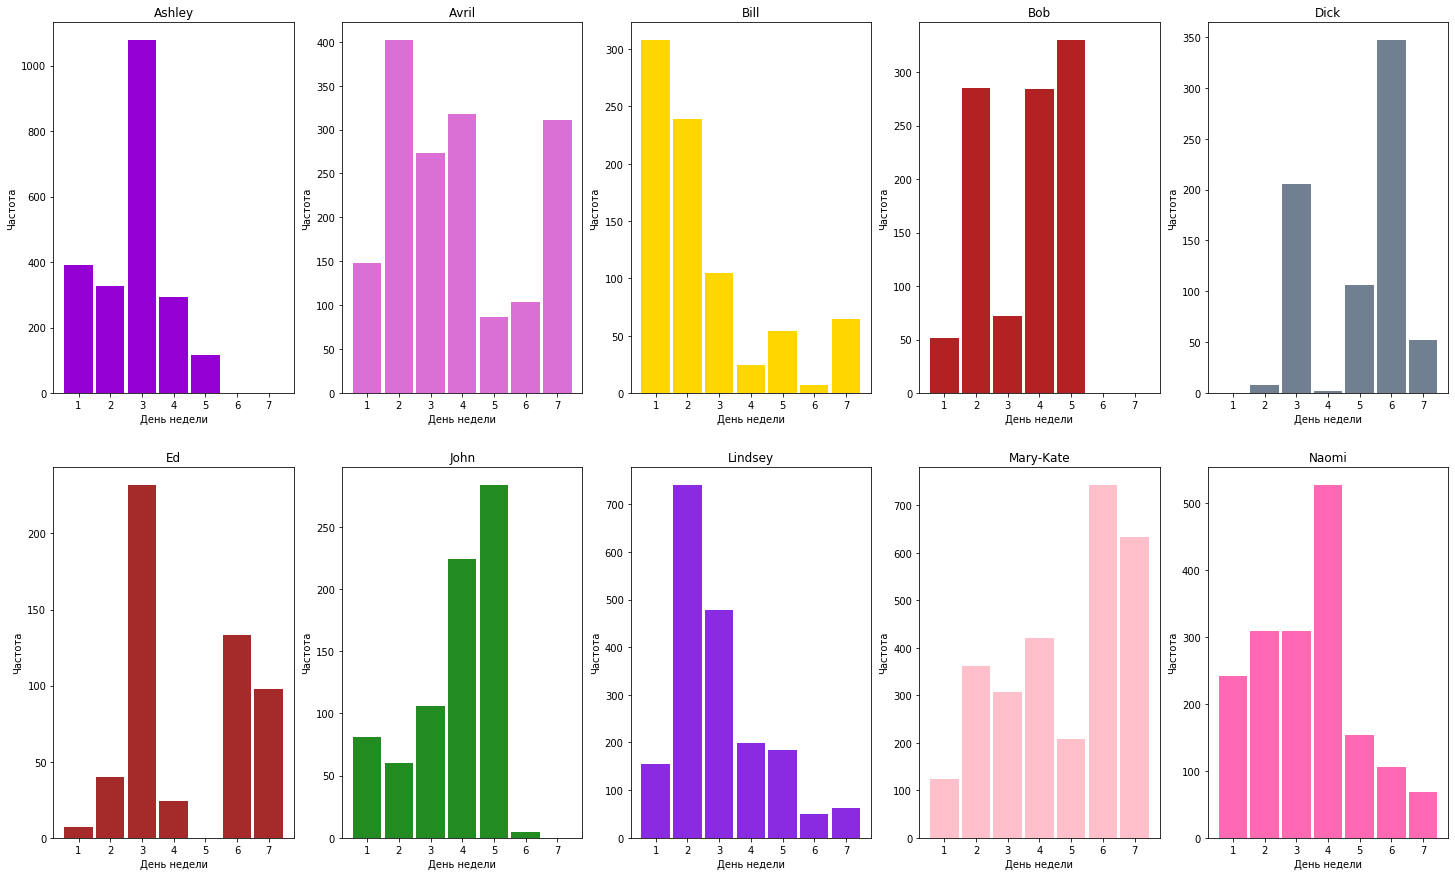

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    axes[idx//5][idx%5].hist(sub_df['day_of_week'], color = color_dic.get(user),  bins = np.arange(0.5,8.5,1) , 
                                      align = 'mid', rwidth = 0.9)
    axes[idx//5][idx%5].set_title(user)
    axes[idx//5][idx%5].set_xlabel('День недели')
    axes[idx//5][idx%5].set_ylabel('Частота')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Ashley:** Часто встречается всего 1 сайт на сессию (возможно обновляет страницу), но в основном кол-во сайтов в сессии 7-9. При этом заметно, что она проводит время в интернете, скорее всего по рабочим делам, так как она не заходит в сеть в выходные, и в будние время только в рабочее время (с падением активности в обеденный перерыв)

**Avril:** Среднее число сайтов в сессии в районе 6, возможно у неё открыто несколько вкладок, между которыми она перемещается (мессенджер или рабочие сайты). Сидит в основном днем, с максимум в районе полудня и 17 часов (также есть спад на обеденный перерыв). При этом заметно падение активности в пятницу и субботу (возможные выходные). А в воскресенье возможно тоже работает (в некоторых странах рабочая неделя начинается с воскресенья, либо делает дз, если она студентка)

**Bill:** Вот у него работа не связана с интернетом, так как максимальная активность утром (возможно за завтраком или по дороге на работу) и в обед. Среднее кол-во сайтов в районе 7-8, возможно любит читать новости, нажимая на новые ссылки. При этом пик активности приходится на понедельник и вторник. В остальные дни активность заметно снижается.

**Bob:** Правктически аналогично Биллу (активность с утра и в обед). А рабочии дни либо вторник, среда и пятница. Либо остальные, если он не сидит в интернете на работе. Меня настораживает, что в выходные у людей маленькая активность. Рад за них)

**Dick:** Скорее всего он сидит в интернете в свободное время. Нерабочие дни среда и суббота. В обед он не сидит в интернете, а под вечер активность слегка меньше, так как, возможно он едет по пятницам (где тоже активность заметно меньше, если учитывать пятницу за выходной) в клуб/бар. Либо же как раз приезжая с работы он сидит вечером в интернете.

**Ed:** Такое ощущение, что это школьник, так как пик активности приходится на 16 часов (пришел домой и еще не сел за уроки), а в учебное время, очевидно меньше времени проводит в интернете. Поэтому же и пики приходятся на выходные. Смущает только среда (возможно, урок программирования в этот день, либо выходной)

**John:** Еще один работяга, так как время активности приходится на рабочие дни в рабочее время, с небольшой просадкой в обед. В выходные отдыхает от сети

**Lindsey:** Сложно сказать, скорее всего тоже работает в интернете, с отдыхом от сети. Неизвестно с чем связан всплеск активности после полудня.

**Mary-Kate** Студентка, возможно. Активно использует интернет во все дни недели с пиком в выходные и под вечер. Однако активность днем в рабочие дни тоже значительная, т.е. использует активно компьютер (по учебе/работе). Под вечер отдыхает/делает дз.

**Naomi** По всей видимости, использует интернет на работе, так как пик приходится на рабочее время и будние дни. Однако вечером и в выходные отдыхает (активность есть, но меньшая)

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [40]:
freq_dict = pickle.load(open(os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),"rb"))

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [43]:
sort_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1][1], reverse=True))
top10_sites = [] 
top10_freqs = []
flag = 0
for k, v in sort_dict.items():
    top10_sites.append(k)
    top10_freqs.append(v[1])
    flag+=1
    if flag==10:
        break

print(top10_freqs)
print(top10_sites) 

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]
['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

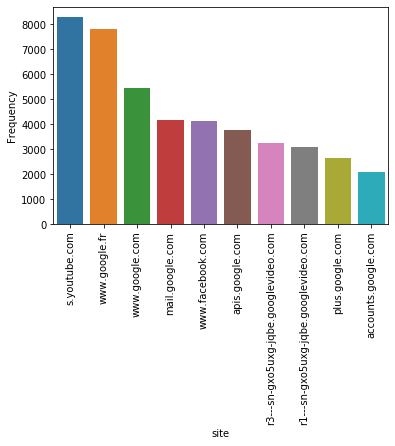

In [61]:
top_df = pd.DataFrame()
top_df['site'] = top10_sites
top_df['Frequency'] = top10_freqs
sns.barplot(x = 'site', y = 'Frequency', data = top_df)
plt.xticks(rotation=90)
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [62]:
np.median(train_data_10users['session_timespan'])

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [63]:
np.median(train_data_10users['day_of_week'])

3.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [66]:
np.median(train_data_150users['start_hour'])

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [67]:
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [114]:
def feature_engineering(path_to_csv_files, features, freq_dict_top, session_length=10, window_size=10):
        
    file_names = glob(path_to_csv_files+'/*') #список файлов в директории
    os.chdir(path_to_csv_files)
    #freq_dict = pickle.load(open(site_freq_path,"rb")) #загружаем словарь

    df = pd.DataFrame(columns=features) #создаем пустой DataFrame
    
    C = np.array([]) #Создаем пустой массив 
    format_data = "%Y-%m-%d %H:%M:%S"
    C = np.array([])
    for name in file_names: #Пробегаемся по всем файлам
        data = pd.read_csv(name)
        sites = np.hstack(np.array(data.site))
        X = []
        #Аналогично считываем все времена в одну строку
        time = np.array(data['timestamp']) #Считываем время
        time = [str(a) for a in time] #Переводим в строку 
        date = [dt.strptime(a, format_data) for a in time] #Переводим строку в дату
        timestamp = [a.timestamp() for a in date] #Переводим в timestamp
        
        userID = name
        userID = userID.replace(path_to_csv_files+'/user', '')
        userID = userID.replace('.csv', '')
        target = int(userID)
        
        for i in range(0, len(time), window_size): #Переформируем 1D массив в матрицу соответствующую размерам в длины сессии/окна
            month = date[i].month
            day = date[i].day
            year = date[i].year
            if len(sites[i:i+session_length]) == session_length:
                if date[i].hour < 18:
                    Evening = 0
                else:
                    Evening = 1
                if 'www.facebook.com' in sites[i:i+session_length]:
                    Facebook = 1
                else:
                    Facebook = 0
                top30_time = np.sum([timestamp[i+1]-timestamp[i] if (x in freq_dict_top) else 0 for x in sites[i:i+session_length-1]])
                top30_flag = np.sum([1 if (x in freq_dict_top) else 0 for x in sites[i:i+session_length]])
                X.append(np.hstack((day, month, year, Evening, Facebook, top30_time, top30_flag, target)))
                
                
                
            else: #Если сессия обрезается, дополняем нулями
                month = date[i].month
                day = date[i].day
                year = date[i].year
                if date[i].hour < 18:
                    Evening = 0
                else:
                    Evening = 1
                if 'www.facebook.com' in sites[i:len(sites)]:
                    Facebook = 1
                else:
                    Facebook = 0
                top30_time = np.sum([timestamp[i+1]-timestamp[i] if (x in freq_dict_top) else 0 for x in sites[i:len(sites)-1]])
                top30_flag = np.sum([1 if (x in freq_dict_top) else 0 for x in sites[i:len(sites)]])
                X.append(np.hstack((day, month, year,Evening, Facebook, top30_time, top30_flag, target)))
        
        #Добавляем сайты в строку

        if len(C) ==0: #Соединяем матрицы для каждого файла в одну (если начальная  пустая матрица, то просто присваиваем)
            C = X
        else:
            C = np.concatenate((C, X), axis=0) 
    
    for i, col in enumerate(features):
        df[col] = C[:,i]
                            
    return(df)

In [150]:
new_feature_names = ['day', 'month', 'year', 'Evening', 'Facebook', 'top30_time', 'top30_count', 'target_name']

In [151]:
freq_dict10 = pickle.load(open(os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),"rb"))
md = dict(sorted(freq_dict10.items(), key=lambda item: item[1][1], reverse=True))
top30_dict10 = {k: md[k] for k in list(md)[:30]}

freq_dict150 = pickle.load(open(os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),"rb"))
md150 = dict(sorted(freq_dict10.items(), key=lambda item: item[1][1], reverse=True))
top30_dict150 = {k: md150[k] for k in list(md150)[:30]}

In [152]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  features=new_feature_names, freq_dict_top = top30_dict10, session_length=10) 

CPU times: user 2.77 s, sys: 71.1 ms, total: 2.84 s
Wall time: 2.91 s


In [153]:
new_features_10users.head()

,day,month,year,Evening,Facebook,top30_time,top30_count,target_name
0,15.0,11.0,2013.0,0.0,0.0,0.0,0.0,39.0
1,15.0,11.0,2013.0,0.0,0.0,2.0,3.0,39.0
2,15.0,11.0,2013.0,0.0,0.0,0.0,0.0,39.0
3,15.0,11.0,2013.0,0.0,0.0,168.0,3.0,39.0
4,15.0,11.0,2013.0,0.0,0.0,0.0,2.0,39.0


In [154]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  features=new_feature_names, freq_dict_top = top30_dict150, session_length=10)

CPU times: user 27.8 s, sys: 1.12 s, total: 28.9 s
Wall time: 30.7 s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [155]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['target_name'] = new_features_10users['target_name'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

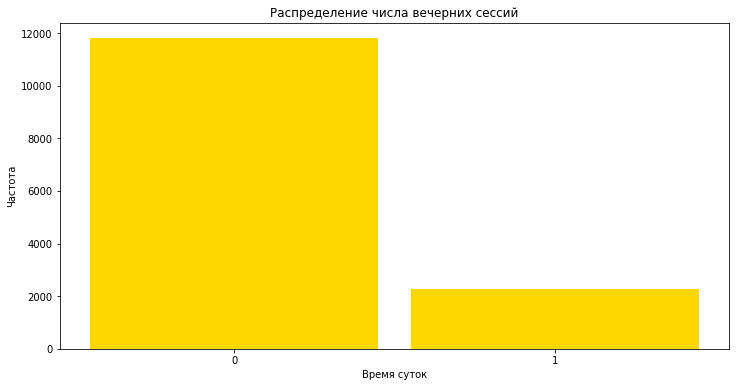

In [111]:
plt.figure(figsize=(12, 6))
plt.hist(new_features_10users['Evening'], color = 'gold', bins = np.arange(-0.5,2.5,1) , align = 'mid', rwidth = 0.9)
plt.xticks(np.arange(0,2,1))
plt.title('Распределение числа вечерних сессий') #0 - не вечер, 1 - вечер
plt.xlabel('Время суток')
plt.ylabel('Частота')
plt.show()

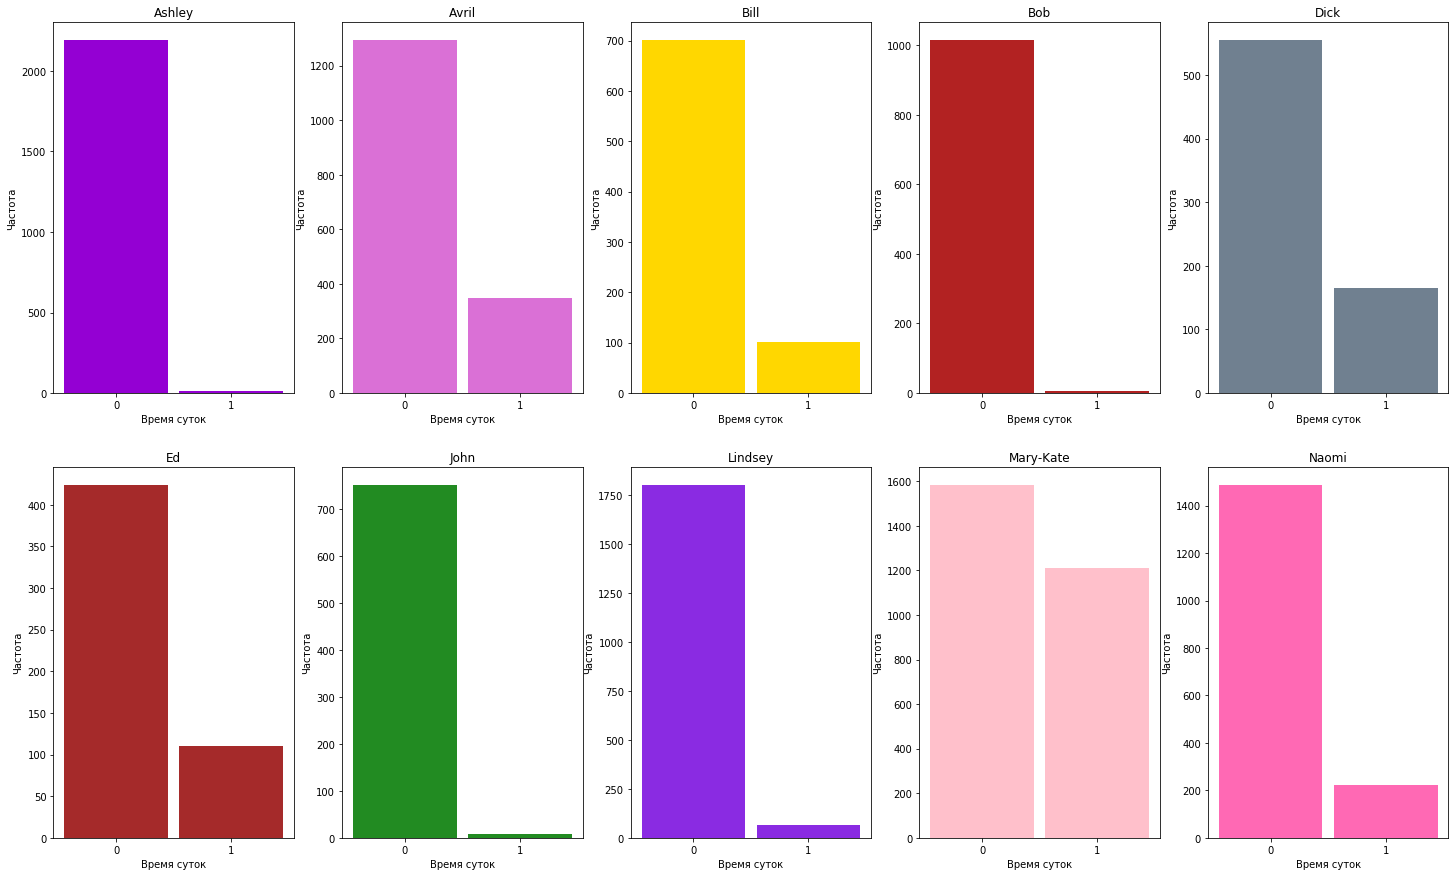

In [124]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target_name')): 
    axes[idx//5][idx%5].hist(sub_df['Evening'], color = color_dic.get(user),  bins = np.arange(-0.5,2.5,1) , 
                             align = 'mid', rwidth = 0.9)
    axes[idx//5][idx%5].set_title(user)
    axes[idx//5][idx%5].set_xticks(np.arange(0,2,1))
    axes[idx//5][idx%5].set_xlabel('Время суток')
    axes[idx//5][idx%5].set_ylabel('Частота')

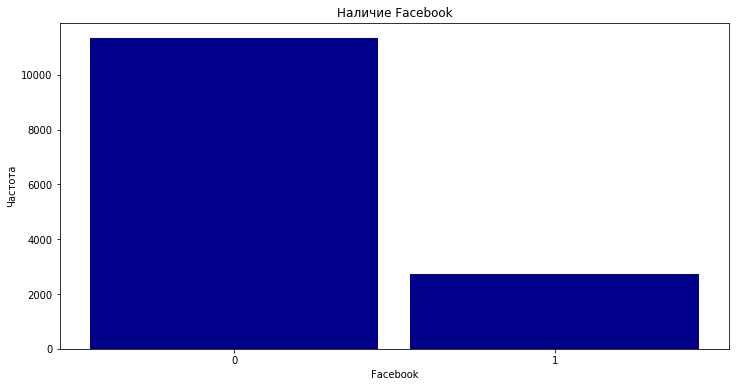

In [113]:
plt.figure(figsize=(12, 6))
plt.hist(new_features_10users['Facebook'], color = 'darkblue', bins = np.arange(-0.5,2.5,1) , align = 'mid', rwidth = 0.9)
plt.xticks(np.arange(0,2,1))
plt.title('Наличие Facebook') #1 - есть Facebook, 0 - нет Facebook
plt.xlabel('Facebook')
plt.ylabel('Частота')
plt.show()

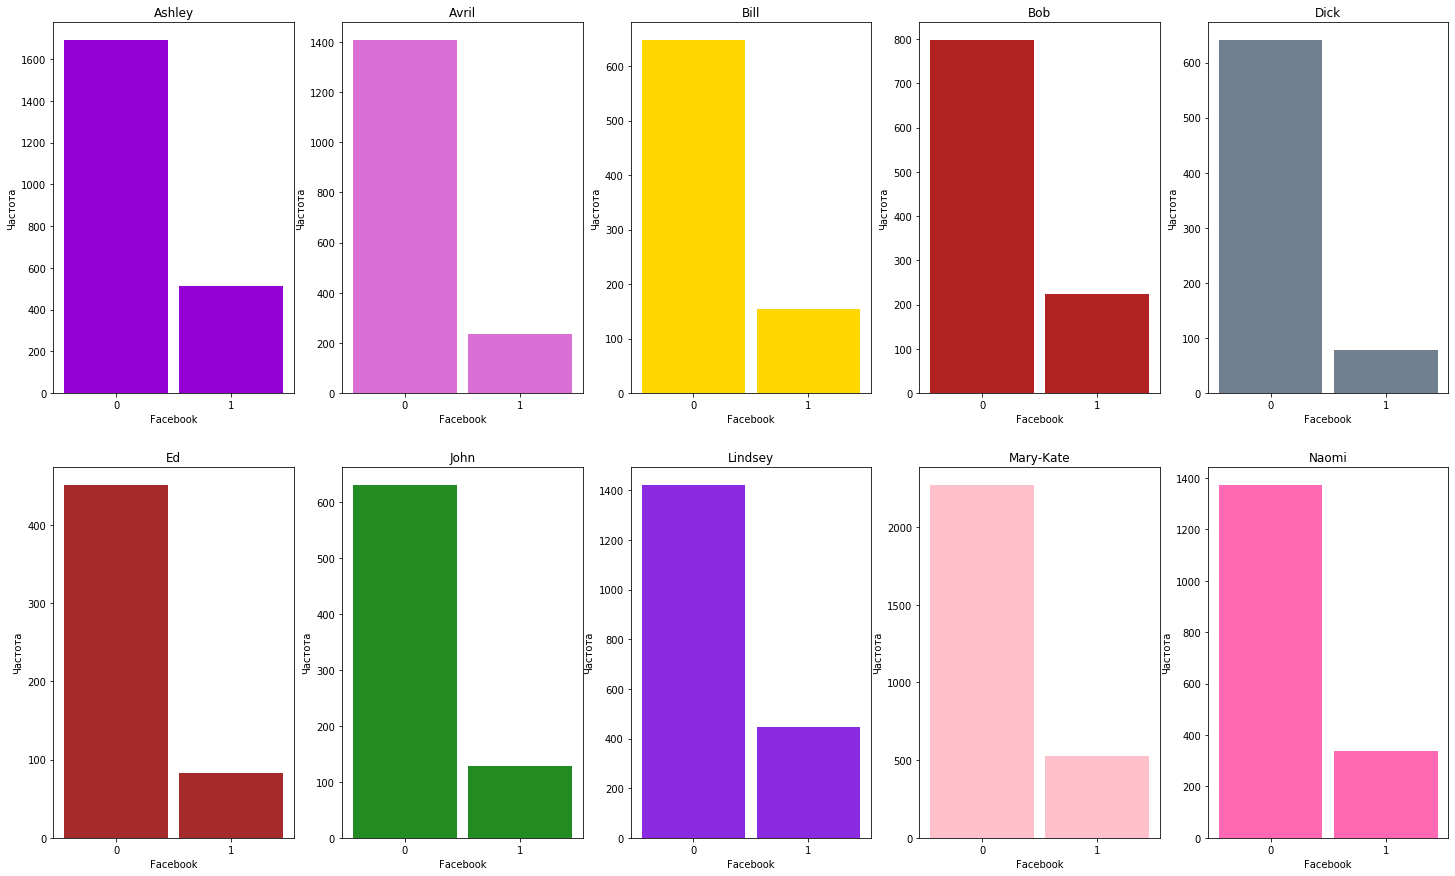

In [126]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target_name')): 
    axes[idx//5][idx%5].hist(sub_df['Facebook'], color = color_dic.get(user),  bins = np.arange(-0.5,2.5,1) , 
                             align = 'mid', rwidth = 0.9)
    axes[idx//5][idx%5].set_title(user)
    axes[idx//5][idx%5].set_xticks(np.arange(0,2,1))
    axes[idx//5][idx%5].set_xlabel('Facebook')
    axes[idx//5][idx%5].set_ylabel('Частота')

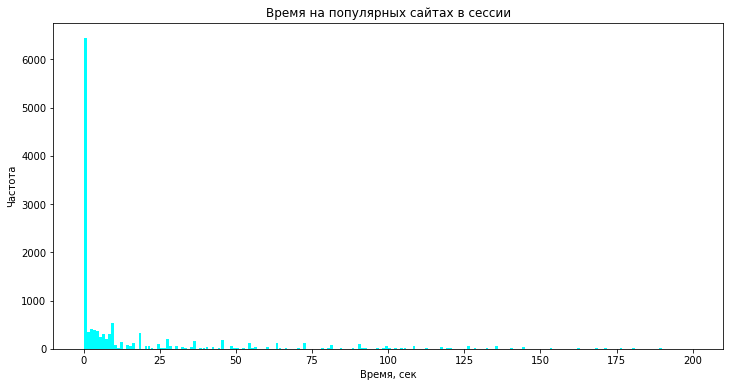

In [134]:
plt.figure(figsize=(12, 6))
plt.hist(new_features_10users['top30_time'], color = 'cyan', bins = 200 , align = 'mid', rwidth = 0.9, range = (0,200))
#plt.xticks(np.arange(0,2,1))
plt.title('Время на популярных сайтах в сессии') #0 - не вечер, 1 - вечер
plt.xlabel('Время, сек')
plt.ylabel('Частота')
plt.show()

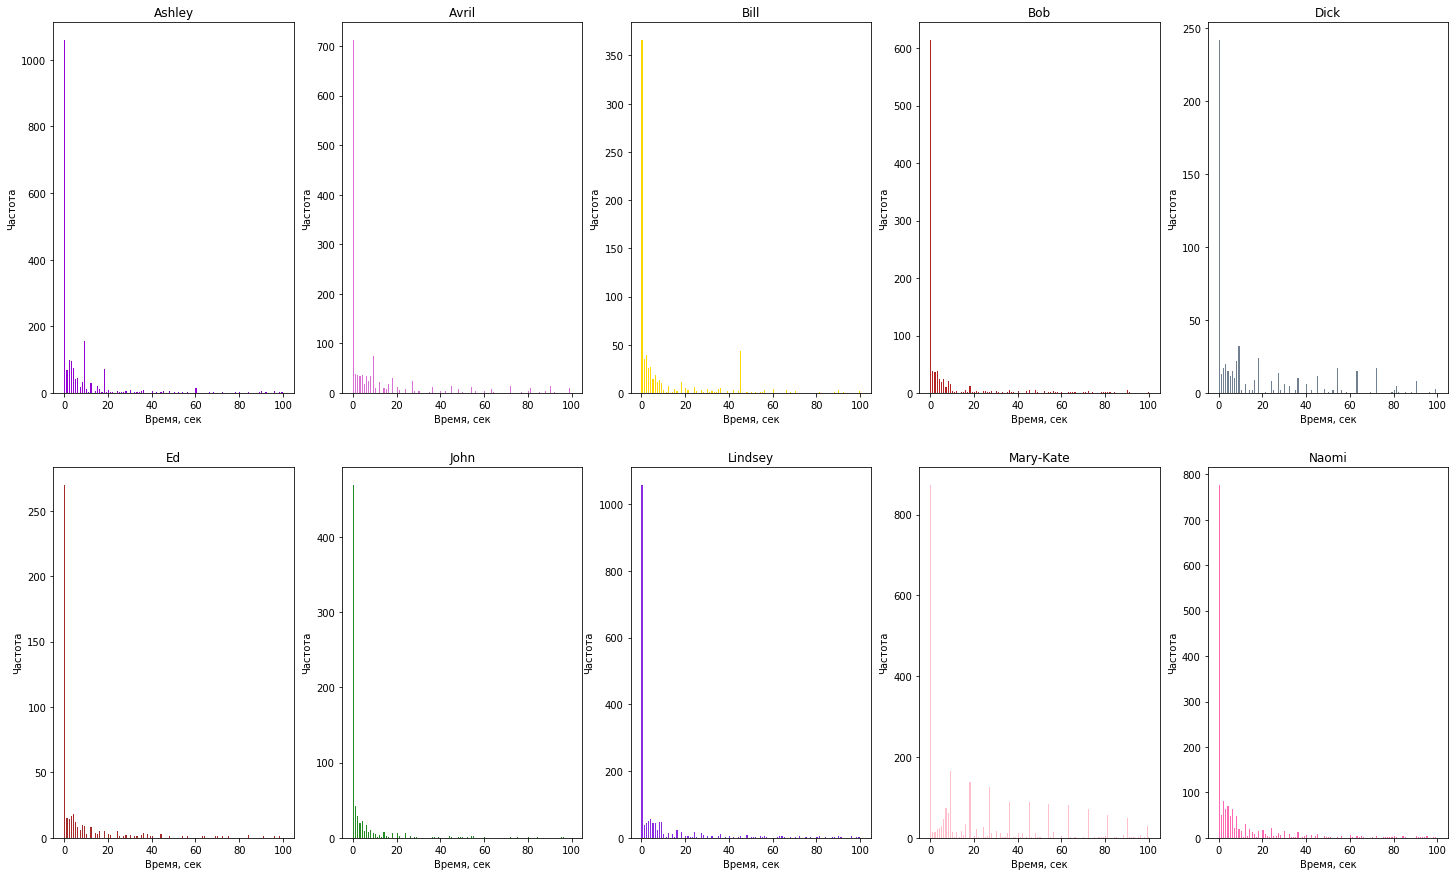

In [143]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target_name')): 
    axes[idx//5][idx%5].hist(sub_df['top30_time'], color = color_dic.get(user),  bins = 200, 
                             align = 'mid', rwidth = 1, range = (0,100))
    axes[idx//5][idx%5].set_title(user)
    #axes[idx//5][idx%5].set_xticks(np.arange(0,2,1))
    axes[idx//5][idx%5].set_xlabel('Время, сек')
    axes[idx//5][idx%5].set_ylabel('Частота')

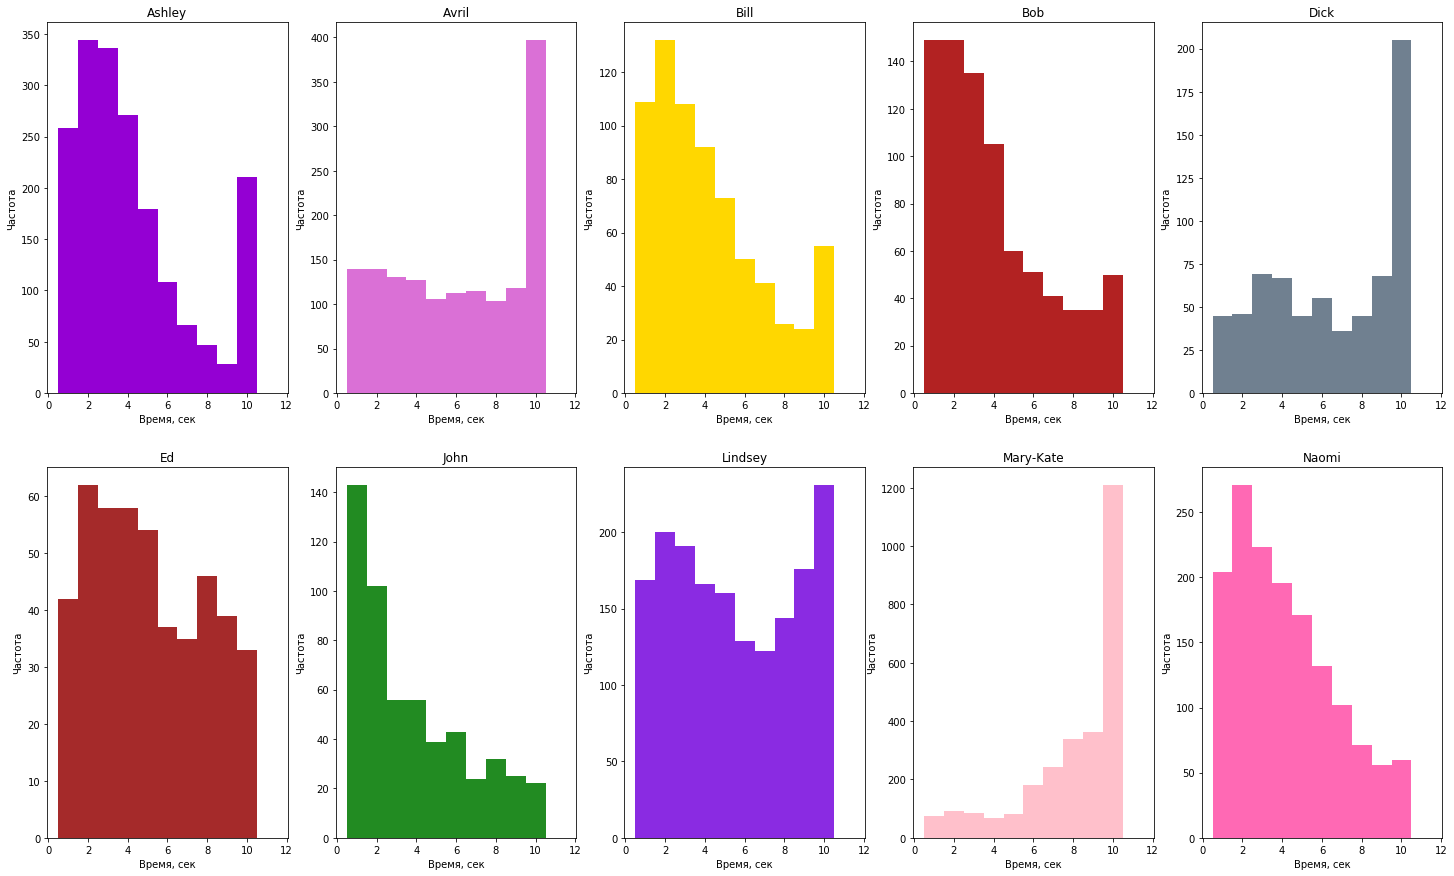

In [158]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15))

for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target_name')): 
    axes[idx//5][idx%5].hist(sub_df['top30_count'], color = color_dic.get(user),  bins = np.arange(0.5, 12.5, 1), 
                             align = 'mid', rwidth = 1, range = (0,100))
    axes[idx//5][idx%5].set_title(user)
    #axes[idx//5][idx%5].set_xticks(np.arange(0,2,1))
    axes[idx//5][idx%5].set_xlabel('Время, сек')
    axes[idx//5][idx%5].set_ylabel('Частота')

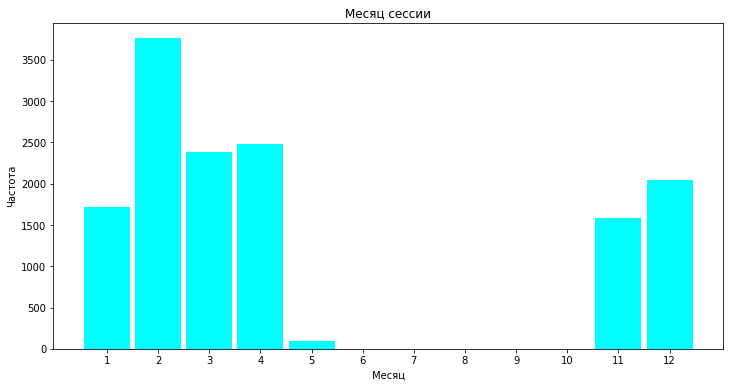

In [142]:
plt.figure(figsize=(12, 6))
plt.hist(new_features_10users['month'], color = 'cyan', bins =  np.arange(0.5, 13.5, 1), align = 'mid', rwidth = 0.9, )
plt.xticks(np.arange(1,13,1))
plt.title('Месяц сессии') #0 - не вечер, 1 - вечер
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.show()

**Вывод:** Не все признаки помогают в идентификации, например, top30_time почти у всех нулевой за сессию. Но характер кол-ва популярных сайтов в сессии довольно разный для разных пользователей. При этом количество посещений Facebook и кол-во вечерних сессий помогут в идентификации. Не уверен, что год/месяц/день как-то помогут изменить ситуацию, тем более, что нет данных для сессий с мая по октябрь.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [164]:
dfn = pd.concat([train_data_10users, new_features_10users], axis=1)
dfn

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,#unique_sites,start_hour,day_of_week,target,day,month,year,Evening,Facebook,top30_time,top30_count,target_name
0,1.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,6.0,0.0,1.0,...,6.0,8.0,5.0,39.0,15.0,11.0,2013.0,0.0,0.0,0.0,0.0,Ashley
1,7.0,8.0,7.0,4.0,9.0,10.0,11.0,12.0,9.0,13.0,1.0,0.0,...,8.0,8.0,5.0,39.0,15.0,11.0,2013.0,0.0,0.0,2.0,3.0,Ashley
2,14.0,15.0,15.0,9.0,15.0,9.0,9.0,4.0,4.0,9.0,0.0,1.0,...,4.0,8.0,5.0,39.0,15.0,11.0,2013.0,0.0,0.0,0.0,0.0,Ashley
3,12.0,15.0,15.0,16.0,17.0,13.0,18.0,19.0,20.0,21.0,56.0,1.0,...,9.0,8.0,5.0,39.0,15.0,11.0,2013.0,0.0,0.0,168.0,3.0,Ashley
4,22.0,23.0,19.0,21.0,24.0,19.0,25.0,26.0,21.0,19.0,0.0,1.0,...,7.0,8.0,5.0,39.0,15.0,11.0,2013.0,0.0,0.0,0.0,2.0,Ashley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,60.0,538.0,538.0,60.0,761.0,52.0,538.0,60.0,761.0,538.0,82.0,109.0,...,4.0,15.0,2.0,237.0,15.0,4.0,2014.0,0.0,0.0,738.0,10.0,Avril
14057,60.0,761.0,52.0,538.0,761.0,60.0,538.0,761.0,761.0,60.0,3.0,268.0,...,4.0,15.0,2.0,237.0,15.0,4.0,2014.0,0.0,0.0,27.0,10.0,Avril
14058,538.0,60.0,761.0,538.0,60.0,16.0,59.0,52.0,538.0,60.0,62.0,4.0,...,6.0,16.0,2.0,237.0,15.0,4.0,2014.0,0.0,0.0,496.0,9.0,Avril
14059,538.0,16.0,60.0,538.0,538.0,761.0,52.0,59.0,761.0,761.0,0.0,0.0,...,6.0,16.0,2.0,237.0,15.0,4.0,2014.0,0.0,0.0,0.0,9.0,Avril


In [165]:
selected_features_10users = pd.concat([train_data_10users, new_features_10users], 
                                      axis=1).drop(['day', 'month', 'year'], axis=1)
selected_features_150users = pd.concat([train_data_150users, new_features_150users],
                                       axis=1).drop(['day', 'month', 'year'], axis=1)

In [166]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 